# Type S Error Analysis: Comparing Fixed Horizon and Sequential Experiment

A Type S error is an error of *sign* when our clamed sign of parameter is to the opposite of the truth. See detailed discussion in this [blog article](https://statmodeling.stat.columbia.edu/2004/12/29/type_1_type_2_t/) and [paper](http://www.stat.columbia.edu/~gelman/research/published/francis8.pdf).

This example is taken from the post [Is Bayesian A/B Testing Immune to Peeking? Not Exactly](http://varianceexplained.org/r/bayesian-ab-testing/), which discusses about the impact of experiment design, fixed horizon or sequantial design, on the Type S error rate.

In [1]:
using Random
using Plots

using BayesianExperiments

Suppose we have one new feature and we want to compare it to the old one.
And the new feature will actually decrease our clickthrough rate from $0.1%$ to $.09%$.
We can use two Bernoulli distributions to represent the data generating processes.

In [2]:
θ1 = 0.0010
θ2 = 0.0009
datagendistA = Bernoulli(θ1)
datagendistB = Bernoulli(θ2)
datagendists = [datagendistA, datagendistB];

We start our model with priors $α=10$ and $β=90$.

In [3]:
α = 10
β = 90
modelA = ConjugateBernoulli(α, β)
modelB = ConjugateBernoulli(α, β)
models = [modelA, modelB]
modelnames = ["old", "new"];

We want to use "expected loss" as the key metric for our decision, and a "threshold of caring" of 0.00001 as the stopping rule of our experiment.

In [4]:
thresh = 0.00001
stoppingrule = ExpectedLossThresh(thresh);

Now we can setup the experiment. 

In [5]:
experiment = ExperimentAB(models, stoppingrule, modelnames=modelnames);

## Fixed Horizon

We can run simulation to analyze how will this experiment perform in reality. 
For the first simulation, we want to use a fixed horizon that 
we only see the result once after 20 days, and make decision at that point.

In [6]:
simulation_fix = Simulation(
    experiment=experiment,
    datagendists=datagendists,
    maxsteps=20,
    onestepsizes=[10000, 10000],
    minsteps=20
)

Random.seed!(123)
numsteps, winners, metricvals = runsequential(simulation_fix, numsamples=10000, numsims=100)
println("Ratio of new variant wins:", sum(winners .== "new") / 100)

Ratio of new variants wins:0.02


## Sequential Experiment

For the second simulation, we want to use sequential decision that 
we will check the result at the end of each day

In [7]:
simulation_sequential = Simulation(
    experiment=experiment,
    datagendists=datagendists,
    maxsteps=20,
    onestepsizes=[10000, 10000],
    minsteps=1
)

Random.seed!(124)
numsteps, winners, metricvals = runsequential(simulation_sequential, numsamples=10000, numsims=100)
type_s_error_rate = sum(winners .== "new") / 100
println("Ratio of new variant wins:", type_s_error_rate)

Ratio of new variants wins:0.11


## Expected Loss Thresholds vs. Resulting Loss

In [22]:
thresholds = [collect(range(1e-6, 9e-6, length=5)); collect(range(1.1e-5, 1e-4, length=5))];

In [23]:
α = 100
β = 99900
modelA = ConjugateBernoulli(α, β)
modelB = ConjugateBernoulli(α, β)
models = [modelA, modelB]
modelnames = ["old", "new"];

In [25]:
resulting_losses_fixed = Float64[]
type_s_error_rates_fixed = Float64[]

numsims = 200
Random.seed!(12)
for thresh in thresholds
    stoppingrule = ExpectedLossThresh(thresh)
    experiment = ExperimentAB(models, stoppingrule, modelnames=modelnames)
    simulation = Simulation(
        experiment=experiment,
        datagendists=datagendists,
        maxsteps=20,
        onestepsizes=[10000, 10000],
        minsteps=20
    )
    numsteps, winners, metricvals = runsequential(simulation, numsamples=5000, numsims=numsims)
    type_s_error_rate = sum(winners .== "new") / numsims
    resulting_loss = (θ1 - θ2)*type_s_error_rate
    push!(type_s_error_rates_fixed, type_s_error_rate)
    push!(resulting_losses_fixed, resulting_loss)
    @show thresh, resulting_loss, type_s_error_rate, thresh > resulting_loss
end

(thresh, resulting_loss, type_s_error_rate, thresh > resulting_loss) = (1.0e-6, 0.0, 0.0, true)
(thresh, resulting_loss, type_s_error_rate, thresh > resulting_loss) = (3.0e-6, 5.000000000000002e-7, 0.005, true)
(thresh, resulting_loss, type_s_error_rate, thresh > resulting_loss) = (5.0e-6, 5.000000000000002e-7, 0.005, true)
(thresh, resulting_loss, type_s_error_rate, thresh > resulting_loss) = (7.0e-6, 2.0000000000000008e-6, 0.02, true)
(thresh, resulting_loss, type_s_error_rate, thresh > resulting_loss) = (9.0e-6, 1.0000000000000004e-6, 0.01, true)
(thresh, resulting_loss, type_s_error_rate, thresh > resulting_loss) = (1.1e-5, 2.0000000000000008e-6, 0.02, true)
(thresh, resulting_loss, type_s_error_rate, thresh > resulting_loss) = (3.325e-5, 1.700000000000001e-5, 0.17, true)
(thresh, resulting_loss, type_s_error_rate, thresh > resulting_loss) = (5.55e-5, 1.4000000000000008e-5, 0.14, true)
(thresh, resulting_loss, type_s_error_rate, thresh > resulting_loss) = (7.775e-5, 1.4500000000000

In [29]:
resulting_losses_sequential = Float64[]
type_s_error_rates_sequential = Float64[]

numsims=200
Random.seed!(12)
for thresh in thresholds
    stoppingrule = ExpectedLossThresh(thresh)
    experiment = ExperimentAB(models, stoppingrule, modelnames=modelnames)
    simulation = Simulation(
        experiment=experiment,
        datagendists=datagendists,
        maxsteps=20,
        onestepsizes=[10000, 10000],
        minsteps=1
    )
    numsteps, winners, metricvals = runsequential(simulation, numsamples=4000, numsims=numsims)
    type_s_error_rate = sum(winners .== "new") / numsims
    resulting_loss = (θ1 - θ2)*type_s_error_rate
    push!(type_s_error_rates_sequential, type_s_error_rate)
    push!(resulting_losses_sequential, resulting_loss)
    @show thresh, resulting_loss, type_s_error_rate, thresh > resulting_loss
end

(thresh, resulting_loss, type_s_error_rate, thresh > resulting_loss) = (1.0e-6, 0.0, 0.0, true)
(thresh, resulting_loss, type_s_error_rate, thresh > resulting_loss) = (3.0e-6, 1.0000000000000004e-6, 0.01, true)
(thresh, resulting_loss, type_s_error_rate, thresh > resulting_loss) = (5.0e-6, 1.0000000000000004e-6, 0.01, true)
(thresh, resulting_loss, type_s_error_rate, thresh > resulting_loss) = (7.0e-6, 3.500000000000002e-6, 0.035, true)
(thresh, resulting_loss, type_s_error_rate, thresh > resulting_loss) = (9.0e-6, 5.000000000000003e-6, 0.05, true)
(thresh, resulting_loss, type_s_error_rate, thresh > resulting_loss) = (1.1e-5, 6.500000000000003e-6, 0.065, true)
(thresh, resulting_loss, type_s_error_rate, thresh > resulting_loss) = (3.325e-5, 2.8500000000000012e-5, 0.285, true)
(thresh, resulting_loss, type_s_error_rate, thresh > resulting_loss) = (5.55e-5, 4.600000000000002e-5, 0.46, true)
(thresh, resulting_loss, type_s_error_rate, thresh > resulting_loss) = (7.775e-5, 4.3000000000000

From the plot below we can find the resulting loss is always below the threshold set in our stopping rule.

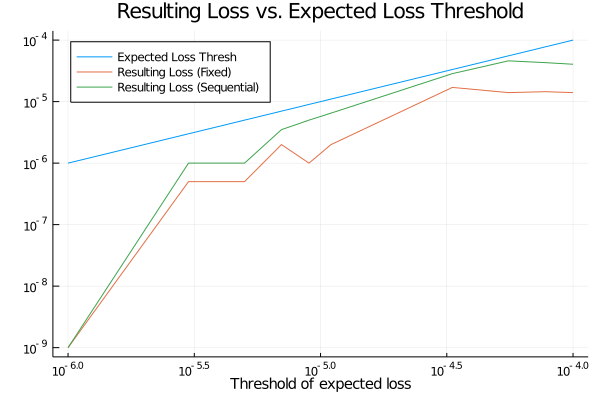

In [30]:
#Adding a small number to 0's to support log-scale plots.
mask = resulting_losses_fixed .== 0.0
resulting_losses_fixed[mask]  .= 1e-9
mask = resulting_losses_sequential .== 0.0
resulting_losses_sequential[mask]  .= 1e-9

plot(thresholds, 
    [thresholds, resulting_losses_fixed, resulting_losses_sequential], 
    xaxis=:log, 
    yaxis=:log, 
    title="Resulting Loss vs. Expected Loss Threshold",
    label=["Expected Loss Thresh" "Resulting Loss (Fixed)" "Resulting Loss (Sequential)"],
    legend=:topleft, 
    xlabel="Threshold of expected loss",
    xguidefontsize=10
)

The Type S error in the sequential experiment is more sensitive to the threshold we chose. As you can see from the plot below, the Type S error increases rapidly when the threshold gets bigger.

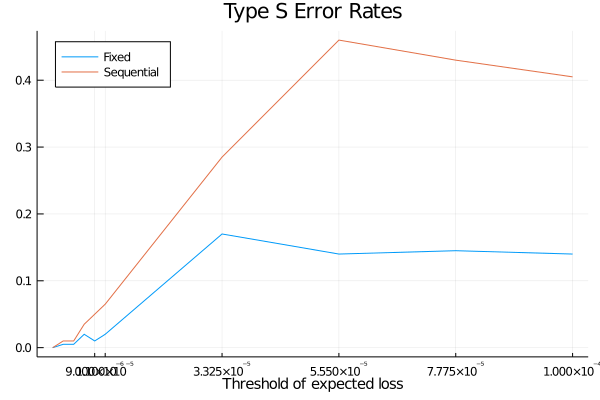

In [31]:
plot(thresholds, 
    [type_s_error_rates_fixed, type_s_error_rates_sequential], 
    title="Type S Error Rates",
    label=["Fixed" "Sequential"],
    legend=:topleft,
    xticks=thresholds[5:end],
    xlabel="Threshold of expected loss",
    xguidefontsize=10
)